<a href="https://colab.research.google.com/github/ersozbasak/Machine-Learning-Regression-Models/blob/master/22_23_LSTM_New_Eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
#mpl.rcParams['figure.figsize'] = (17, 5)
#mpl.rcParams['axes.grid'] = False
#sns.set_style("whitegrid")
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf
import csv

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NEW_ENG_LMP

/content/drive/MyDrive/NEW_ENG_LMP


In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/NEW_ENG_LMP/lmp_rt_final_NEW_ENG.csv',engine='python',encoding='utf-8')

In [ ]:
df_1.head()

,Date,Hour Ending,Location ID,Location Name,Location Type,Locational Marginal Price,Energy Component,Congestion Component,Marginal Loss Component
0,06/01/2022,1,46728,LD.2121A_T 34.5,NETWORK NODE,75.47,75.47,1.26,-1.26
1,06/01/2022,2,46728,LD.2121A_T 34.5,NETWORK NODE,79.10,78.13,1.51,-0.54
2,06/01/2022,3,46728,LD.2121A_T 34.5,NETWORK NODE,93.96,94.43,0.13,-0.60
3,06/01/2022,4,46728,LD.2121A_T 34.5,NETWORK NODE,110.48,111.09,0.00,-0.61
4,06/01/2022,5,46728,LD.2121A_T 34.5,NETWORK NODE,133.10,133.43,0.00,-0.33


In [ ]:
columns_to_drop = ['Date', 'Location ID', 'Location Type', 'Energy Component', 'Congestion Component', 'Marginal Loss Component']
df_1.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df_1.head()

,Hour Ending,Location Name,Locational Marginal Price
0,1,LD.2121A_T 34.5,75.47
1,2,LD.2121A_T 34.5,79.10
2,3,LD.2121A_T 34.5,93.96
3,4,LD.2121A_T 34.5,110.48
4,5,LD.2121A_T 34.5,133.10


In [ ]:
columns_to_drop = ['Hour Ending']
df_1.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df_1.head()

,Location Name,Locational Marginal Price
0,LD.2121A_T 34.5,75.47
1,LD.2121A_T 34.5,79.10
2,LD.2121A_T 34.5,93.96
3,LD.2121A_T 34.5,110.48
4,LD.2121A_T 34.5,133.10


In [ ]:
# extract unique 'NODE' values for each dataframe
node1 = set(df_1['Location Name'].unique())

In [ ]:
# filter dataframes to keep only common 'NODE' values
df_filtered = df_1[df_1['Location Name'].isin(node1)]

In [ ]:
# concatenate the filtered dataframes
merged_df_1 = pd.concat([df_filtered])

In [ ]:
merged_df_1.head()

,Location Name,Locational Marginal Price
0,LD.2121A_T 34.5,75.47
1,LD.2121A_T 34.5,79.10
2,LD.2121A_T 34.5,93.96
3,LD.2121A_T 34.5,110.48
4,LD.2121A_T 34.5,133.10


In [ ]:
# applying the method
count_nan = merged_df_1.isnull().sum()

# printing the number of values present
# in the column
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: Location Name                0
Locational Marginal Price    0
dtype: int64


In [ ]:
# group the merged_df dataframe by the 'NODE' column
grouped_df = merged_df_1.groupby('Location Name')

# get the names of each group
group_names = grouped_df.groups.keys()

node_list = []

# iterate through the grouped dataframe, get each group by its name, and append it to the node_list
for key, item in grouped_df:
    node_df = grouped_df.get_group(key)
    node_list.append(node_df)

stacked_df = []

# iterate through the node_list, drop the 'NODE' column, stack the dataframe, and append it to the stacked_df
for i in node_list:
    i_drop = i.drop('Location Name', axis=1)
    s_df = i_drop.stack().reset_index(drop=True)
    stacked_df.append(s_df)

node_dfs = {}
df_list = []

# iterate through the group_names, create a dataframe for each node, and append it to the df_list
for i, node in enumerate(group_names):
    node_dfs[node] = pd.DataFrame(stacked_df[i], columns=[node])
    df_list.append(node_dfs[node])

# concatenate the dataframes in the df_list along the columns to get the final dataframe
df_1 = pd.concat(df_list, axis=1)

In [ ]:
df_1

,HC.AYER 115,LD.2121A_T 34.5,LD.5CORNRS 13.2T1 LD,LD.5CORNRS 13.2T2 LD,LD.9DRAGONS115,LD.ACUSHNET13.2,LD.ALLINGS 13.8,LD.AMHERST 34.5,LD.ANDREWSQ13.8110AC LD,LD.ANSONIA 13.8,LD.ASHFIELD23,UN.9DRAGONS115 BOIS
0,75.98,75.47,77.42,77.42,74.57,77.18,55.70,76.32,77.10,75.84,77.29,74.57
1,78.99,79.10,80.18,80.18,78.27,80.05,50.49,79.47,80.10,78.06,80.39,78.27
2,93.71,93.96,95.32,95.32,92.89,94.90,51.56,94.41,95.01,92.73,96.00,92.89
3,110.17,110.48,111.98,111.98,108.83,111.46,49.55,111.07,111.68,108.71,113.07,108.83
4,132.44,133.10,134.34,134.34,130.35,133.90,48.90,133.54,134.27,130.04,135.60,130.35
...,...,...,...,...,...,...,...,...,...,...,...,...
8779,59.33,58.52,59.16,59.16,44.63,60.14,NaN,58.89,60.15,57.66,57.82,44.63
8780,39.41,38.30,39.46,39.46,1.61,40.04,NaN,39.07,39.98,38.54,38.67,1.61
8781,41.52,40.17,41.71,41.71,37.06,42.19,NaN,41.22,42.12,40.78,41.05,37.06
8782,35.68,34.64,35.98,35.98,33.85,36.24,NaN,35.46,36.20,35.01,35.42,33.85


In [ ]:
count_nan = df_1.isnull().sum()
print('Number of NaN values present: ' + str(count_nan))


Number of NaN values present: HC.AYER    115                0
LD.2121A_T 34.5               0
LD.5CORNRS 13.2T1 LD          0
LD.5CORNRS 13.2T2 LD          0
LD.9DRAGONS115                0
LD.ACUSHNET13.2               0
LD.ALLINGS 13.8            1080
LD.AMHERST 34.5               0
LD.ANDREWSQ13.8110AC LD       0
LD.ANSONIA 13.8               0
LD.ASHFIELD23                 0
UN.9DRAGONS115 BOIS           0
dtype: int64


In [ ]:
df_1.dropna(inplace=True)

In [ ]:

df_1.head()

,HC.AYER 115,LD.2121A_T 34.5,LD.5CORNRS 13.2T1 LD,LD.5CORNRS 13.2T2 LD,LD.9DRAGONS115,LD.ACUSHNET13.2,LD.ALLINGS 13.8,LD.AMHERST 34.5,LD.ANDREWSQ13.8110AC LD,LD.ANSONIA 13.8,LD.ASHFIELD23,UN.9DRAGONS115 BOIS
0,75.98,75.47,77.42,77.42,74.57,77.18,55.70,76.32,77.10,75.84,77.29,74.57
1,78.99,79.10,80.18,80.18,78.27,80.05,50.49,79.47,80.10,78.06,80.39,78.27
2,93.71,93.96,95.32,95.32,92.89,94.90,51.56,94.41,95.01,92.73,96.00,92.89
3,110.17,110.48,111.98,111.98,108.83,111.46,49.55,111.07,111.68,108.71,113.07,108.83
4,132.44,133.10,134.34,134.34,130.35,133.90,48.90,133.54,134.27,130.04,135.60,130.35


In [ ]:
count_nan = df_1.isnull().sum()
print('Number of NaN values present: ' + str(count_nan))


Number of NaN values present: HC.AYER    115             0
LD.2121A_T 34.5            0
LD.5CORNRS 13.2T1 LD       0
LD.5CORNRS 13.2T2 LD       0
LD.9DRAGONS115             0
LD.ACUSHNET13.2            0
LD.ALLINGS 13.8            0
LD.AMHERST 34.5            0
LD.ANDREWSQ13.8110AC LD    0
LD.ANSONIA 13.8            0
LD.ASHFIELD23              0
UN.9DRAGONS115 BOIS        0
dtype: int64


## LSTM Entegrasyon

In [ ]:
df_1.head()

,HC.AYER 115,LD.2121A_T 34.5,LD.5CORNRS 13.2T1 LD,LD.5CORNRS 13.2T2 LD,LD.9DRAGONS115,LD.ACUSHNET13.2,LD.ALLINGS 13.8,LD.AMHERST 34.5,LD.ANDREWSQ13.8110AC LD,LD.ANSONIA 13.8,LD.ASHFIELD23,UN.9DRAGONS115 BOIS
0,75.98,75.47,77.42,77.42,74.57,77.18,55.70,76.32,77.10,75.84,77.29,74.57
1,78.99,79.10,80.18,80.18,78.27,80.05,50.49,79.47,80.10,78.06,80.39,78.27
2,93.71,93.96,95.32,95.32,92.89,94.90,51.56,94.41,95.01,92.73,96.00,92.89
3,110.17,110.48,111.98,111.98,108.83,111.46,49.55,111.07,111.68,108.71,113.07,108.83
4,132.44,133.10,134.34,134.34,130.35,133.90,48.90,133.54,134.27,130.04,135.60,130.35


In [ ]:
df = df_1
df

,HC.AYER 115,LD.2121A_T 34.5,LD.5CORNRS 13.2T1 LD,LD.5CORNRS 13.2T2 LD,LD.9DRAGONS115,LD.ACUSHNET13.2,LD.ALLINGS 13.8,LD.AMHERST 34.5,LD.ANDREWSQ13.8110AC LD,LD.ANSONIA 13.8,LD.ASHFIELD23,UN.9DRAGONS115 BOIS
0,75.98,75.47,77.42,77.42,74.57,77.18,55.70,76.32,77.10,75.84,77.29,74.57
1,78.99,79.10,80.18,80.18,78.27,80.05,50.49,79.47,80.10,78.06,80.39,78.27
2,93.71,93.96,95.32,95.32,92.89,94.90,51.56,94.41,95.01,92.73,96.00,92.89
3,110.17,110.48,111.98,111.98,108.83,111.46,49.55,111.07,111.68,108.71,113.07,108.83
4,132.44,133.10,134.34,134.34,130.35,133.90,48.90,133.54,134.27,130.04,135.60,130.35
...,...,...,...,...,...,...,...,...,...,...,...,...
7699,34.48,33.03,34.49,34.49,31.36,34.42,59.00,34.09,34.34,35.44,34.62,31.36
7700,41.98,40.15,42.01,42.01,38.12,41.90,39.55,41.48,41.79,43.31,42.24,38.12
7701,28.43,27.29,28.46,28.46,26.14,28.36,41.83,28.11,28.31,29.28,28.61,26.14
7702,22.97,22.11,22.97,22.97,21.32,22.92,35.92,22.76,22.93,23.53,23.11,21.32


In [ ]:
class LSTM():
    def __init__(self, lookback, features, forecast):
        self.lookback = lookback
        self.features = features
        self.forecast = forecast


    def df_1(self, dataframe, lookback, features, forecast):
        df_1 = dataframe.values
        # Create the X and y arrays
        self.X, self.y = [], []
        for i in range(self.lookback, len(df_1) - self.forecast):
            self.X.append(df_1[i-self.lookback:i])
            self.y.append(df_1[i:i+self.forecast, 0]) # USD feature

      # Reshape the X and y arrays
        self.X, self.y = np.array(self.X), np.array(self.y)
        self.X = np.reshape(self.X, (self.X.shape[0], self.X.shape[1], self.features)) # (batch_size, lookback, features)
        self.y = np.reshape(self.y, (self.y.shape[0], self.forecast)) # (batch_size, forecast)

        return self.X, self.y


In [ ]:
lstm = LSTM(lookback=11, features=12, forecast=1)

In [ ]:
X_all, y_all = lstm.df_1(dataframe = df_1, lookback = 11, features = 12, forecast = 1)

In [ ]:
X_all

array([[[ 75.98,  75.47,  77.42, ...,  75.84,  77.29,  74.57],
        [ 78.99,  79.1 ,  80.18, ...,  78.06,  80.39,  78.27],
        [ 93.71,  93.96,  95.32, ...,  92.73,  96.  ,  92.89],
        ...,
        [ 67.32,  70.02,  67.93, ...,  66.23,  67.93,  66.65],
        [ 63.75,  66.07,  64.31, ...,  62.83,  64.31,  62.96],
        [ 61.7 ,  63.33,  62.5 , ...,  61.23,  62.49,  60.  ]],

       [[ 78.99,  79.1 ,  80.18, ...,  78.06,  80.39,  78.27],
        [ 93.71,  93.96,  95.32, ...,  92.73,  96.  ,  92.89],
        [110.17, 110.48, 111.98, ..., 108.71, 113.07, 108.83],
        ...,
        [ 63.75,  66.07,  64.31, ...,  62.83,  64.31,  62.96],
        [ 61.7 ,  63.33,  62.5 , ...,  61.23,  62.49,  60.  ],
        [ 64.52,  65.61,  65.45, ...,  64.25,  65.46,  61.81]],

       [[ 93.71,  93.96,  95.32, ...,  92.73,  96.  ,  92.89],
        [110.17, 110.48, 111.98, ..., 108.71, 113.07, 108.83],
        [132.44, 133.1 , 134.34, ..., 130.04, 135.6 , 130.35],
        ...,
        [ 61

In [ ]:
y_all

array([[64.52],
       [66.29],
       [92.73],
       ...,
       [41.98],
       [28.43],
       [22.97]])

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3,random_state=123)

In [ ]:
print(y_all.max())
print(X_all.max())
print(y_all.min())
print(X_all.min())

print(np.mean(y_all))
print(np.mean(X_all))

2252.63
2283.78
-85.82
-87.34
68.26814222568903
67.33486435139224


In [ ]:
print("X_train shape : {}".format(X_train.shape))
print("y_train shape : {}".format(y_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_test shape : {}".format(y_test.shape))


X_train shape : (5384, 11, 12)
y_train shape : (5384, 1)
X_test shape : (2308, 11, 12)
y_test shape : (2308, 1)


In [ ]:

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
def create_model(l_rate, epoch, batchsize, x_train_data, y_train_data):

  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,mode='min', restore_best_weights=True)#ceed
  lstm_model = tf.keras.Sequential()
  #lstm_model.add(tf.keras.layers.LSTM(256,activation='relu',input_shape=(lstm.lookback, lstm.features),return_sequences=True))
  lstm_model.add(tf.keras.layers.LSTM(128,activation='relu',input_shape=(lstm.lookback, lstm.features),return_sequences=True))
  lstm_model.add(tf.keras.layers.LSTM(64,activation='relu',input_shape=(lstm.lookback, lstm.features),return_sequences=True))
  lstm_model.add(tf.keras.layers.LSTM(32,activation='relu'))
  lstm_model.add(tf.keras.layers.Dense(units=lstm.forecast))

  opt = tf.optimizers.Adam(learning_rate=l_rate)
  lstm_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=opt,
    metrics=[tf.metrics.MeanAbsoluteError()]
    )

  lstm_history = lstm_model.fit(x_train_data, y_train_data,
    epochs=epoch,
    batch_size = batchsize,
    verbose=1,
    validation_split = 0.2,
    shuffle=False
    #callbacks = [early_stopping]
    )

  return lstm_history, lstm_model


In [ ]:
history, model = create_model(l_rate = 0.001, epoch = 400, batchsize = 256, x_train_data = X_train, y_train_data = y_train)

Epoch 1/400
17/17 [==============================] - 10s 234ms/step - loss: 3027.2390 - mean_absolute_error: 34.9314 - val_loss: 5453.7378 - val_mean_absolute_error: 27.4180
Epoch 2/400
17/17 [==============================] - 2s 138ms/step - loss: 1685.9230 - mean_absolute_error: 23.1009 - val_loss: 4608.6777 - val_mean_absolute_error: 23.7280
Epoch 3/400
17/17 [==============================] - 2s 134ms/step - loss: 1763.4918 - mean_absolute_error: 22.8812 - val_loss: 4376.0435 - val_mean_absolute_error: 25.9408
Epoch 4/400
17/17 [==============================] - 2s 138ms/step - loss: 2775.1445 - mean_absolute_error: 30.4211 - val_loss: 5192.5908 - val_mean_absolute_error: 25.5835
Epoch 5/400
17/17 [==============================] - 3s 166ms/step - loss: 1980.3864 - mean_absolute_error: 24.6743 - val_loss: 4342.1885 - val_mean_absolute_error: 24.6778
Epoch 6/400
17/17 [==============================] - 4s 222ms/step - loss: 3606.8899 - mean_absolute_error: 34.6974 - val_loss: 6480.5

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss', linewidth=1,color='green')
    plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=1,color='purple')
    plt.title(title)
    plt.legend()

    plt.show()

<ipython-input-75-6b1627954cc9>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss', linewidth=1,color='green')
<ipython-input-75-6b1627954cc9>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=1,color='purple')


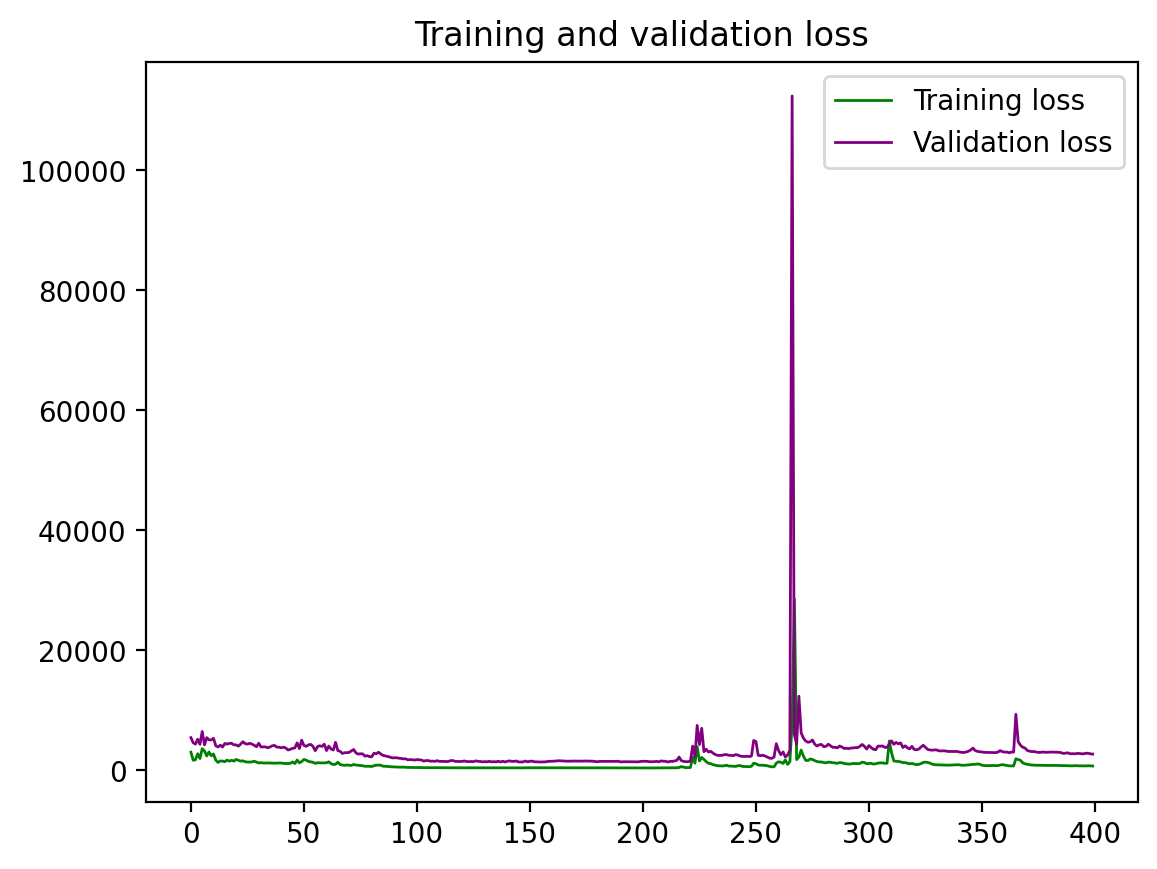

In [ ]:
plot_train_history(history,
                   'Training and validation loss')

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

73/73 [==============================] - 1s 11ms/step


In [ ]:
y_pred

array([[ 56.76892 ],
       [ 33.64048 ],
       [111.69556 ],
       ...,
       [ 93.21893 ],
       [ 22.053093],
       [ 77.63803 ]], dtype=float32)

In [ ]:
y_test

array([[ 66.3 ],
       [ 25.89],
       [108.65],
       ...,
       [ 94.57],
       [ 22.53],
       [100.58]])

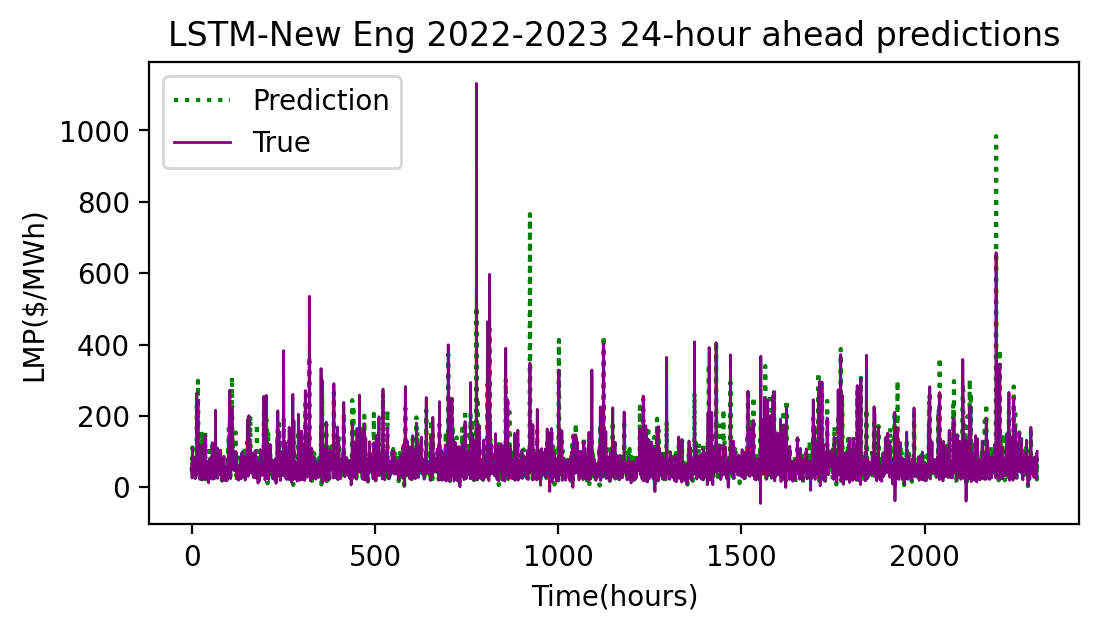

In [ ]:
plt.figure(figsize=(6,3))


plt.xlabel('Time(hours)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022-2023 24-hour ahead predictions")

hour= 24
n_day = 365
plot_day = hour*n_day

plt.plot(y_pred[:,-1], label='Prediction', linestyle='dotted',color='green')
plt.plot(y_test[:, -1], label='True', linewidth=1,color='purple')
plt.legend()
plt.show()

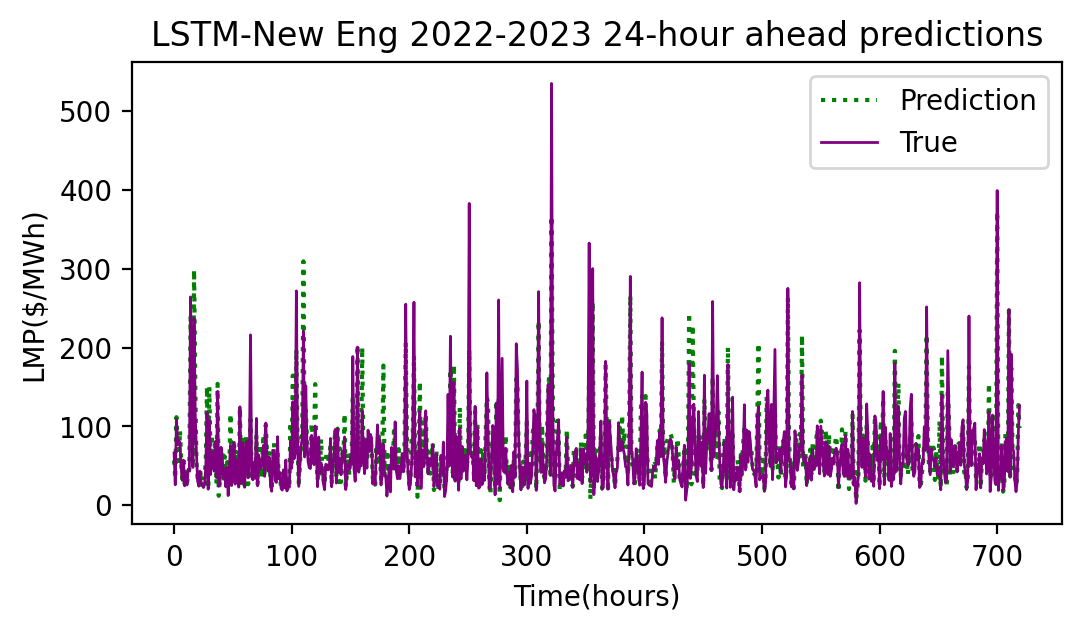

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
# Reshape the y_pred and y_test arrays to have shape (batch_size,)
y_pred_resized = y_pred[:,-1]
y_test_resized = y_test[:,-1]
plt.xlabel('Time(hours)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022-2023 24-hour ahead predictions")

hour= 24
n_day = 30
plot_day = hour*n_day

plt.plot(y_pred_resized[0:plot_day], label='Prediction', linestyle='dotted',color='green')
plt.plot(y_test_resized[0:plot_day], label='True', linewidth=1,color='purple')

plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
errors = y_pred- y_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

print('Mean Absolute Error: {:.2f}'.format(mae))
print('Root Mean Square Error: {:.2f}'.format(rmse))
print('R2 Score: ', r2_score(y_test, y_pred))


Mean Absolute Error: 14.50
Root Mean Square Error: 29.35
R2 Score:  0.7662404866231137


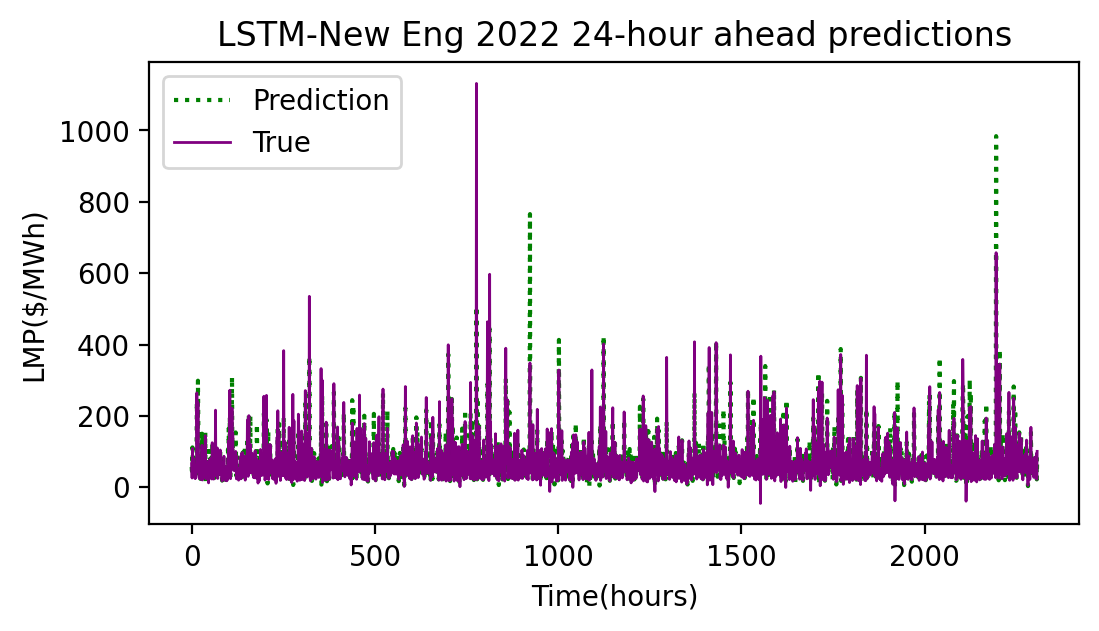

In [ ]:
plt.figure(figsize=(6,3))


plt.xlabel('Time(hours)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022 24-hour ahead predictions")

hour= 24
n_day = 365
plot_day = hour*n_day

plt.plot(y_pred[:,-1], label='Prediction', linestyle='dotted',color='green')
plt.plot(y_test[:, -1], label='True', linewidth=1,color='purple')
plt.legend()
plt.show()

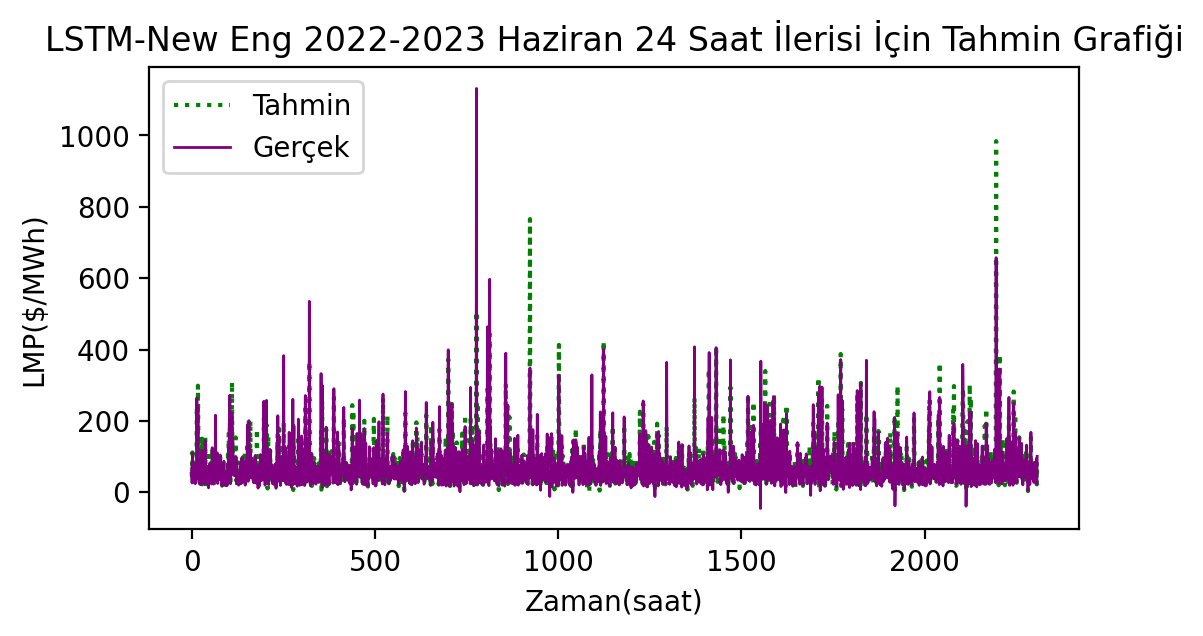

In [ ]:
plt.figure(figsize=(6,3))


plt.xlabel('Zaman(saat)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022-2023 Haziran 24 Saat İlerisi İçin Tahmin Grafiği")

hour= 24
n_day = 365
plot_day = hour*n_day

plt.plot(y_pred[:,-1], label='Tahmin', linestyle='dotted',color='green')
plt.plot(y_test[:, -1], label='Gerçek', linewidth=1,color='purple')
plt.legend()
plt.show()

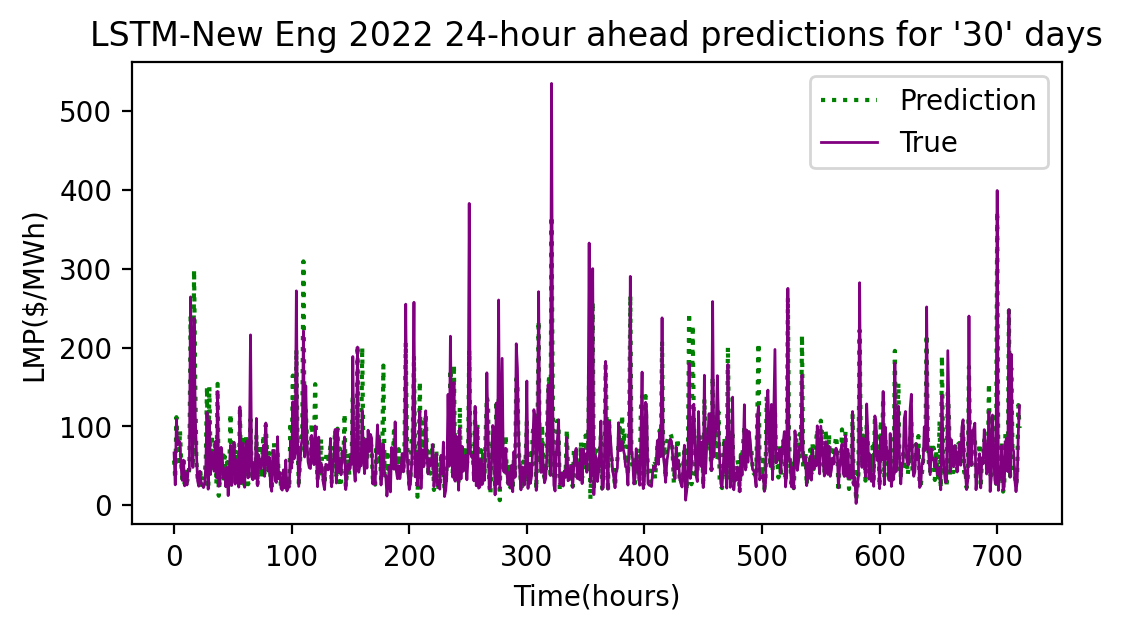

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
# Reshape the y_pred and y_test arrays to have shape (batch_size,)
y_pred_resized = y_pred[:,-1]
y_test_resized = y_test[:,-1]
plt.xlabel('Time(hours)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022 24-hour ahead predictions for '30' days")

hour= 24
n_day = 30
plot_day = hour*n_day

plt.plot(y_pred_resized[0:plot_day], label='Prediction', linestyle='dotted',color='green')
plt.plot(y_test_resized[0:plot_day], label='True', linewidth=1,color='purple')

plt.legend()
plt.show()

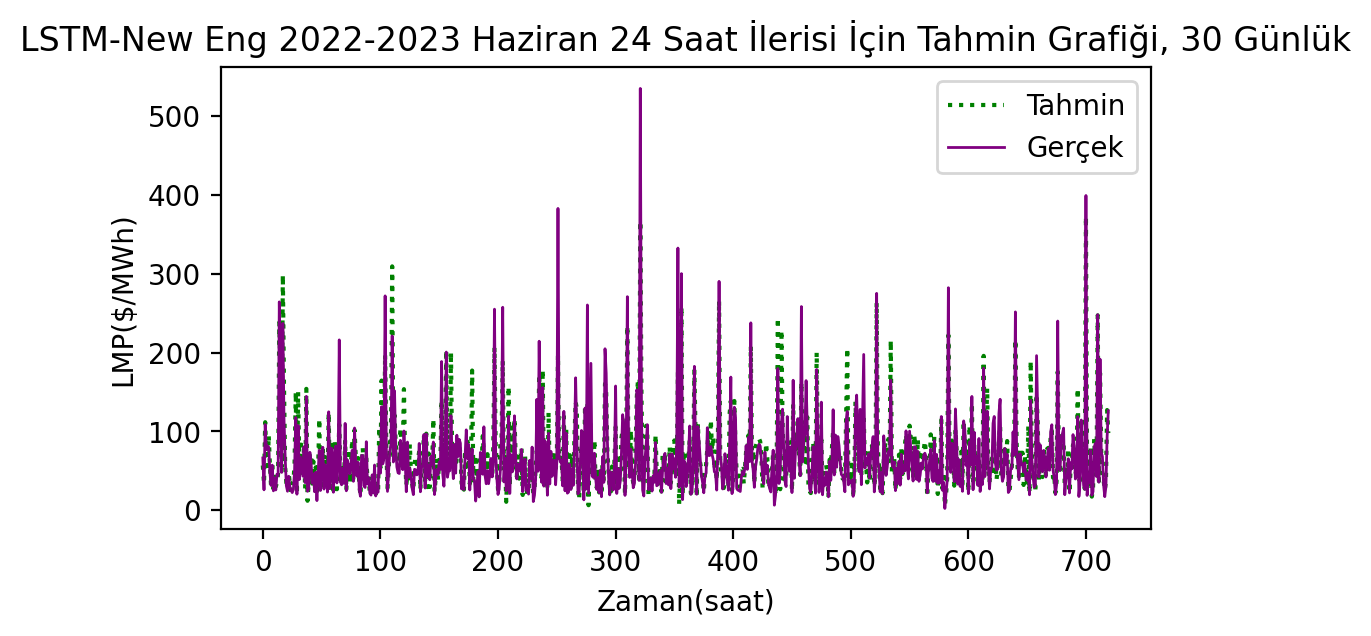

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
# Reshape the y_pred and y_test arrays to have shape (batch_size,)
y_pred_resized = y_pred[:,-1]
y_test_resized = y_test[:,-1]
plt.xlabel('Zaman(saat)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022-2023 Haziran 24 Saat İlerisi İçin Tahmin Grafiği, 30 Günlük")

hour= 24
n_day = 30
plot_day = hour*n_day

plt.plot(y_pred_resized[0:plot_day], label='Tahmin', linestyle='dotted',color='green')
plt.plot(y_test_resized[0:plot_day], label='Gerçek', linewidth=1,color='purple')

plt.legend()
plt.show()

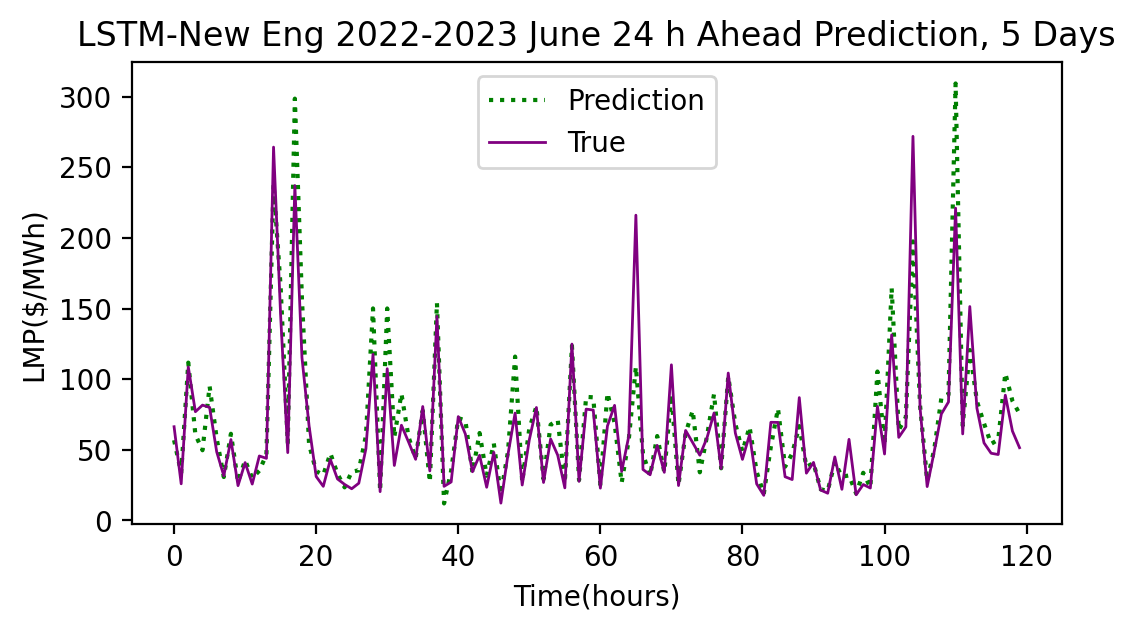

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
# Reshape the y_pred and y_test arrays to have shape (batch_size,)
y_pred_resized = y_pred[:,-1]
y_test_resized = y_test[:,-1]
plt.xlabel('Time(hours)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022-2023 June 24 h Ahead Prediction, 5 Days")

hour= 24
n_day = 5
plot_day = hour*n_day

plt.plot(y_pred_resized[0:plot_day], label='Prediction', linestyle='dotted',color='green')
plt.plot(y_test_resized[0:plot_day], label='True', linewidth=1,color='purple')

plt.legend()
plt.show()

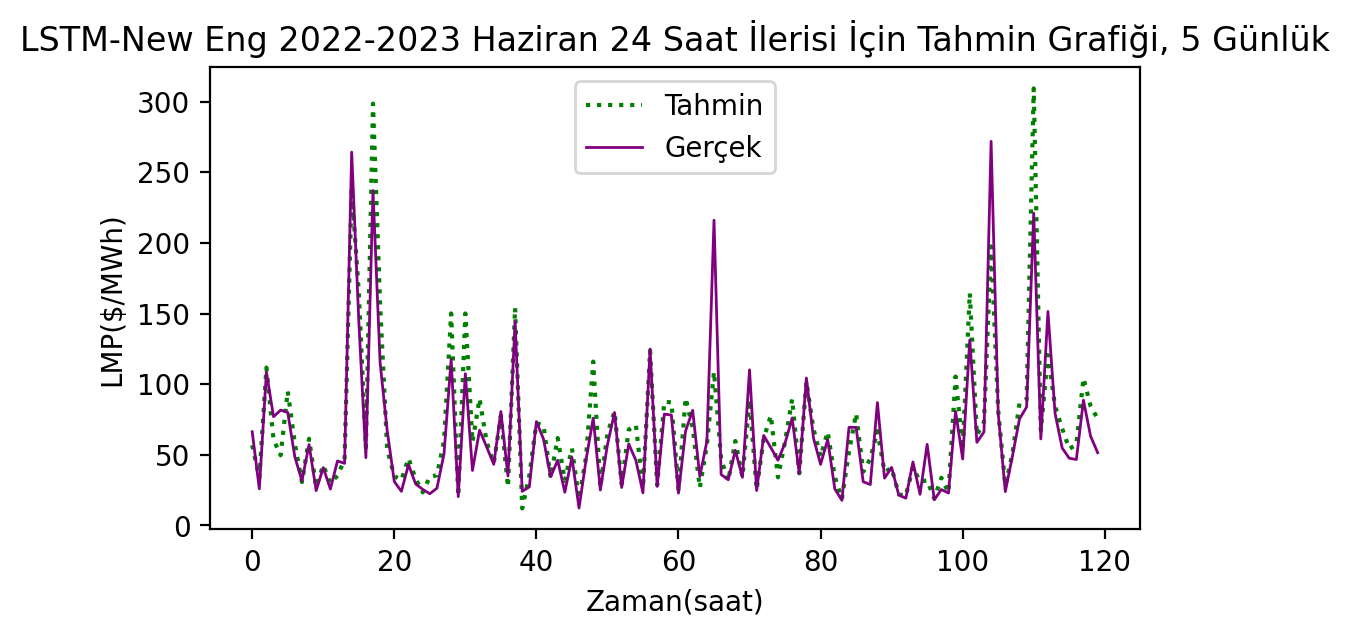

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
# Reshape the y_pred and y_test arrays to have shape (batch_size,)
y_pred_resized = y_pred[:,-1]
y_test_resized = y_test[:,-1]
plt.xlabel('Zaman(saat)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022-2023 Haziran 24 Saat İlerisi İçin Tahmin Grafiği, 5 Günlük")

hour= 24
n_day = 5
plot_day = hour*n_day

plt.plot(y_pred_resized[0:plot_day], label='Tahmin', linestyle='dotted',color='green')
plt.plot(y_test_resized[0:plot_day], label='Gerçek', linewidth=1,color='purple')

plt.legend()
plt.show()

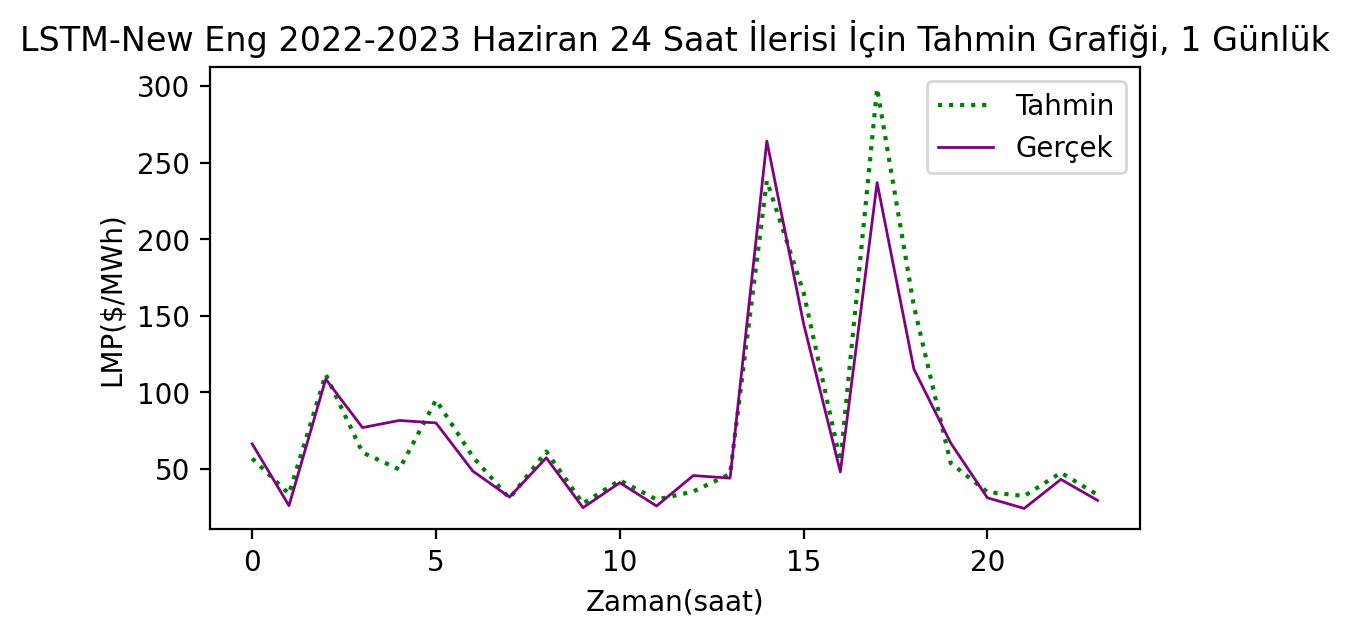

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
# Reshape the y_pred and y_test arrays to have shape (batch_size,)
y_pred_resized = y_pred[:,-1]
y_test_resized = y_test[:,-1]
plt.xlabel('Zaman(saat)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022-2023 Haziran 24 Saat İlerisi İçin Tahmin Grafiği, 1 Günlük")

hour= 24
n_day = 1
plot_day = hour*n_day

plt.plot(y_pred_resized[0:plot_day], label='Tahmin', linestyle='dotted',color='green')
plt.plot(y_test_resized[0:plot_day], label='Gerçek', linewidth=1,color='purple')

plt.legend()
plt.show()

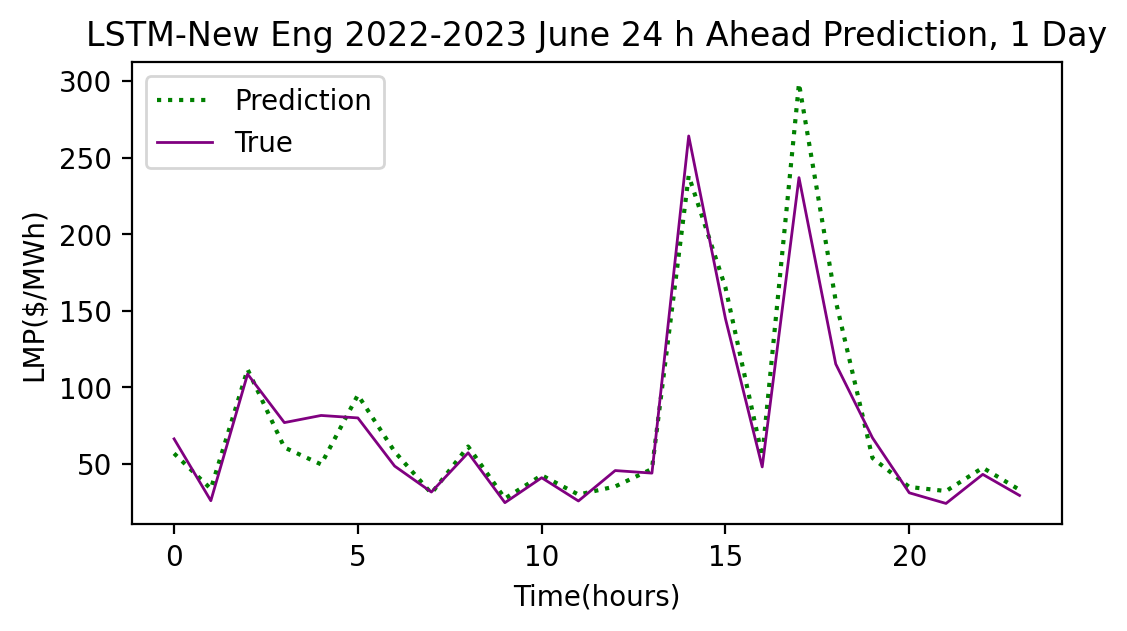

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
# Reshape the y_pred and y_test arrays to have shape (batch_size,)
y_pred_resized = y_pred[:,-1]
y_test_resized = y_test[:,-1]
plt.xlabel('Time(hours)')
plt.ylabel('LMP($/MWh)')
plt.title("LSTM-New Eng 2022-2023 June 24 h Ahead Prediction, 1 Day")

hour= 24
n_day = 1
plot_day = hour*n_day

plt.plot(y_pred_resized[0:plot_day], label='Prediction', linestyle='dotted',color='green')
plt.plot(y_test_resized[0:plot_day], label='True', linewidth=1,color='purple')

plt.legend()
plt.show()